## Import Necessary Libraries

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install contractions

     |████████████████████████████████| 106 kB 8.6 MB/s 
     |████████████████████████████████| 287 kB 51.1 MB/s 


In [ ]:
import nltk

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import numpy as np
import keras
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import contractions
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from collections import defaultdict
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import scikitplot
from scikitplot.metrics import plot_confusion_matrix

# Create a Dataframe for reading and analysing the text files easily

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/Othercomputers/My Laptop/ROTMAN/Spring Term/RSM8521 - AI/Project/Code/'

In [ ]:
df_train = pd.read_csv(path + '/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df_test = pd.read_csv(path + '/test.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test.head()

,Input,Sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
df_val = pd.read_csv(path + '/val.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_val.head()

,Input,Sentiment
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [ ]:
df_train.Sentiment.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64

In [ ]:
df_train.shape

(16000, 2)

In [ ]:
df_test.shape

(2000, 2)

In [ ]:
df_val.shape

(2000, 2)

# Data Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


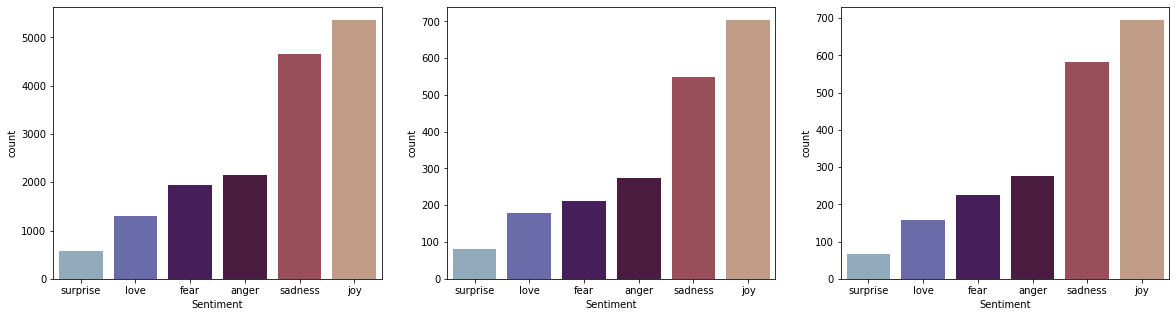

In [ ]:
data_total = [df_train,df_val,df_test]
order=['surprise','love','fear','anger','sadness','joy']
fig,ax = plt.subplots(1,3,figsize=(20,5))
for i,data in enumerate(data_total):
    sns.countplot(data.Sentiment,ax=ax[i], palette='twilight',order=order)

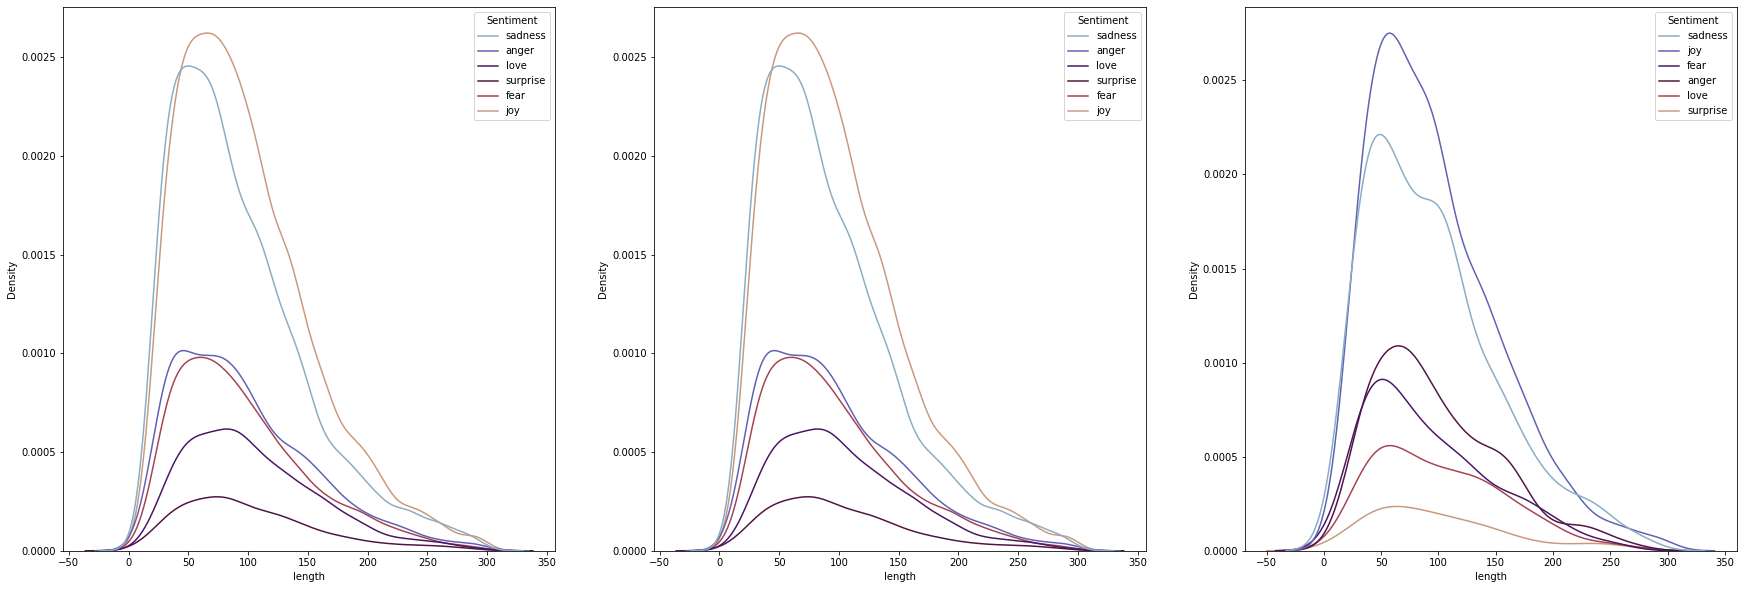

In [ ]:
all_data = {'Train Data': df_train, 'Validation Data': df_train, 'Test Data': df_test}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Input']]
    sns.kdeplot(data=df2,x='length',hue='Sentiment', ax=ax[i],palette='twilight')
plt.show()

In [ ]:
df_train.Input.apply(lambda x:len(x)).max()

300

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [ ]:
stop_words = set(stopwords.words('english')) 
stem = WordNetLemmatizer ()
def clean_text(text):
    text = text.lower()
    text = word_tokenize(text)
    text = [contractions.fix(word) for word in text]
    text = [stem.lemmatize(w,tag_map[tag[0]]) for w, tag in pos_tag(text) if w not in stop_words]
    return " ".join(text)

In [ ]:
for i,data in enumerate(data_total):
    data.Input = data.Input.apply(clean_text)

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        colormap='twilight', 
        scale=3,
        random_state=1 
).generate(str(data))
    return wordcloud

In [ ]:
categories = df_train["Sentiment"].unique()

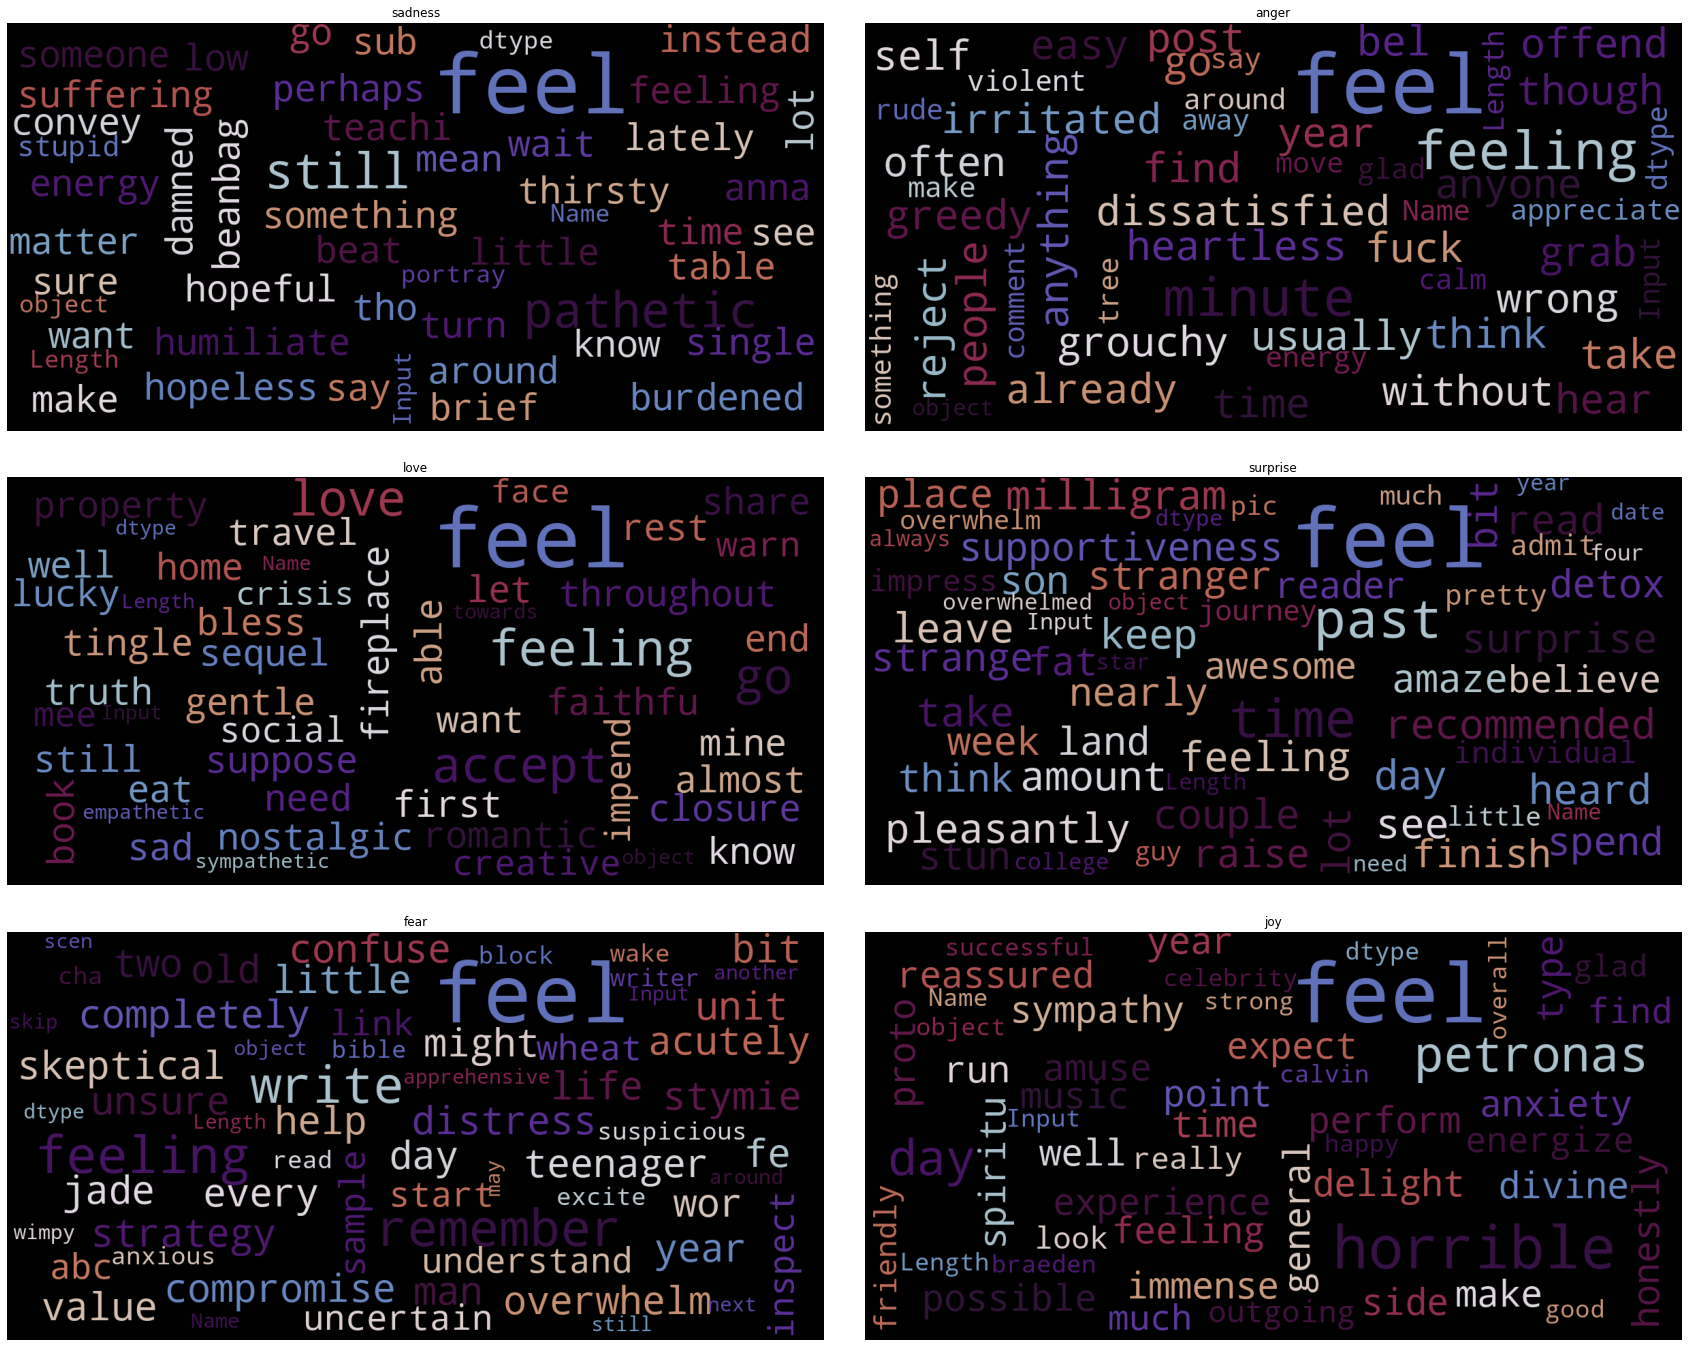

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=3,figsize=(30,25))
plt.axis('off')
for category, ax in zip(categories, axes.flat):
    wordcloud = show_wordcloud(df_train[df_train["Sentiment"]==category]['Input'])
    ax.imshow(wordcloud)
    ax.title.set_text(category)
    ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)

# Text Hammer

In [ ]:
!pip install text_hammer

     |████████████████████████████████| 115 kB 7.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import text_hammer as th

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)


In [ ]:
df_cleaned_train = text_preprocessing(df_train, 'Input')

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

In [ ]:
df_cleaned_train.head()

,Input,Sentiment
0,i do not feel humiliate,sadness
1,i can go from feel so hopeless to so damned ho...,sadness
2,i m grab a minute to post i feel greedy wrong,anger
3,i am ever feel nostalgic about the fireplace i...,love
4,i am feel grouchy,anger


# Reading the Train and Validation Data

In [ ]:
df_train=df_cleaned_train

In [ ]:
X=df_train['Input']

In [ ]:
lst=[]
for i in X:
  lst.append(len(i))

In [ ]:
len1=pd.DataFrame(lst)
len1.describe()

,0
count,16000.000000
mean,94.111125
std,54.438185
min,7.000000
25%,52.000000
50%,83.000000
75%,125.000000
max,295.000000


In [ ]:
#counts length frequency
cts=[]
for i in range(7,301):
   ct=0
   for k in lst:
     if k==i:
       ct+=1
   cts.append(ct)

# Using The tokenizer Class to convert the sentences into word vectors

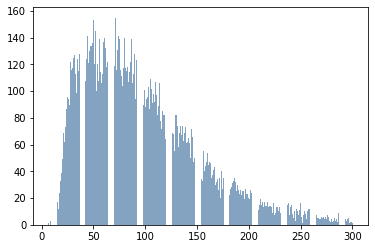

In [ ]:
plt.bar(range(7,301),cts,color=(0.2, 0.4, 0.6, 0.6))
plt.show()

In [ ]:
#number of unique words in the dataset
n=0
vec=[]
for i in X:
  for j in i.split(' '):
    if j not in vec:
      vec.append(j)
len(vec)

12104

In [ ]:
tokenizer=Tokenizer(12104,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(X)

In [ ]:
len(tokenizer.word_index)

12104

In [ ]:
X_train=tokenizer.texts_to_sequences(X)
X_train_pad=pad_sequences(X_train,maxlen=80,padding='post')

In [ ]:
df_train['Sentiment']=df_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [ ]:
Y_train=df_train['Sentiment'].values

# One hot Encoding the Emotion Values

In [ ]:
Y_train_f=to_categorical(Y_train)

In [ ]:
Y_train_f[:6]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
df_cleaned_val = text_preprocessing(df_val, 'Input')
df_val=df_cleaned_val
df_val

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Input,Sentiment
0,i m feel quite sad and sorry for myself but il...,sadness
1,i feel like i am still look at a blank canvas ...,sadness
2,i feel like a faithful servant,love
3,i am just feel cranky and blue,anger
4,i can have for a treat or if i am feel festive,joy
...,...,...
1995,i m have ssa examination tomorrow in the morni...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [ ]:
X_val=df_val['Input']
Y_val=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [ ]:
X_val_f=tokenizer.texts_to_sequences(X_val)
X_val_pad=pad_sequences(X_val_f,maxlen=80,padding='post')

In [ ]:
Y_val_f=to_categorical(Y_val)

In [ ]:
Y_val_f[:6]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension
# more dimension means more deep meaning of words but it may take longer time to download 

In [ ]:
num_words=12104

In [ ]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


# BI-LSTM: Creating a Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout

In [ ]:
model=Sequential()
model.add(Embedding(num_words,100,input_length=80,weights =[gensim_weight_matrix],trainable = False))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 100)           1210400   
                                                                 
 dropout (Dropout)           (None, 80, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 80, 160)          115840    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 80, 160)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 160)          154240    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 320)             

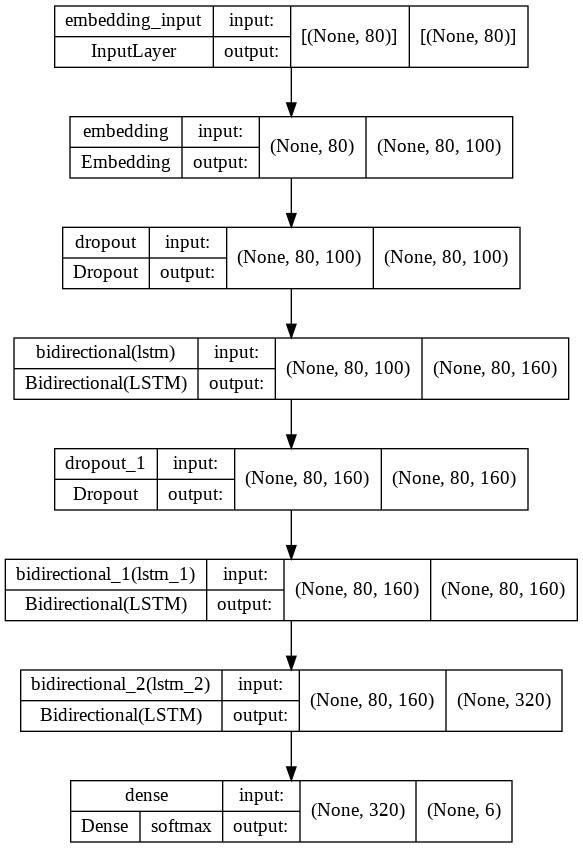

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,show_layer_activations=True,expand_nested=True)

## Original Model

In [ ]:
#Original Model
"""
model=Sequential()
model.add(Embedding(15212,64,input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())
"""

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 64)            973568    
                                                                 
 dropout_2 (Dropout)         (None, 80, 64)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 160)          92800     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 320)              410880    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 1926      
                                                                 
Total params: 1,479,174
Trainable params: 1,479,174
No

## Compiling and running the model

In [ ]:
# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist=model.fit(X_train_pad,Y_train_f,epochs=40,validation_data=(X_val_pad,Y_val_f),callbacks=[es])

Epoch 1/15
500/500 [==============================] - 12s 25ms/step - loss: 0.7149 - accuracy: 0.7384 - val_loss: 0.3546 - val_accuracy: 0.8715
Epoch 2/15
500/500 [==============================] - 11s 22ms/step - loss: 0.3216 - accuracy: 0.8885 - val_loss: 0.2381 - val_accuracy: 0.9100
Epoch 3/15
500/500 [==============================] - 11s 21ms/step - loss: 0.2192 - accuracy: 0.9228 - val_loss: 0.2062 - val_accuracy: 0.9265
Epoch 4/15
500/500 [==============================] - 11s 22ms/step - loss: 0.1765 - accuracy: 0.9367 - val_loss: 0.2033 - val_accuracy: 0.9240
Epoch 5/15
500/500 [==============================] - 11s 22ms/step - loss: 0.1389 - accuracy: 0.9467 - val_loss: 0.1883 - val_accuracy: 0.9235
Epoch 6/15
500/500 [==============================] - 11s 22ms/step - loss: 0.1169 - accuracy: 0.9551 - val_loss: 0.1774 - val_accuracy: 0.9300
Epoch 7/15
500/500 [==============================] - 11s 22ms/step - loss: 0.1009 - accuracy: 0.9611 - val_loss: 0.1730 - val_accuracy:

## Bi-LSTM Plotting the Loss and Accuracy Curves

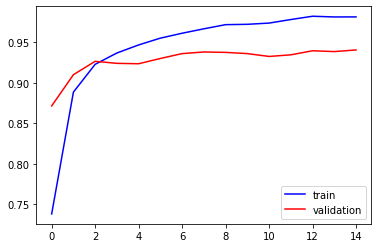

In [ ]:
plt.plot(hist.history['accuracy'],c='b',label='train')
plt.plot(hist.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

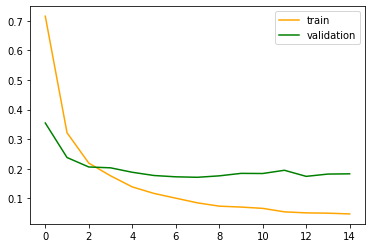

In [ ]:
plt.plot(hist.history['loss'],c='orange',label='train')
plt.plot(hist.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.show()

## Checking for Test Data

In [ ]:
df_cleaned_test = text_preprocessing(df_test, 'Input')
df_test=df_cleaned_test

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
X_test=df_test['Input']
Y_test=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [ ]:
X_test_f=tokenizer.texts_to_sequences(X_test)
X_test_pad=pad_sequences(X_test_f,maxlen=80,padding='post')

In [ ]:
Y_test_f=to_categorical(Y_test)

In [ ]:
X_test_pad.shape

(2000, 80)

In [ ]:
Y_test_f[:7]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

## Accuracy for Test Data

In [ ]:
model.evaluate(X_test_pad,Y_test_f)

63/63 [==============================] - 1s 10ms/step - loss: 0.2000 - accuracy: 0.9325


[0.20002131164073944, 0.9325000047683716]

## Plotting the Confusion matrix 

In [ ]:
Y_pred=model.predict(X_test_pad)
classes_x=np.argmax(Y_pred,axis=1)

In [ ]:
#'joy':0,
#'anger':1,
#'love':2,
#'sadness':3,
#'fear':4,
#'surprise':5

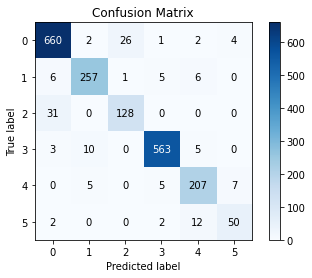

In [ ]:
plot_confusion_matrix(Y_test,classes_x)

In [ ]:
print(classification_report(Y_test,classes_x))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       695
           1       0.94      0.93      0.94       275
           2       0.83      0.81      0.82       159
           3       0.98      0.97      0.97       581
           4       0.89      0.92      0.91       224
           5       0.82      0.76      0.79        66

    accuracy                           0.93      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



# Creating a Function to check for Your own Sentence

In [ ]:
def get_key(value):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    for key,val in dictionary.items():
          if (val==value):
            return key

In [ ]:
def predict(sentence):
  sentence_lst=[]
  sentence_lst.append(sentence)
  sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
  sentence_padded=pad_sequences(sentence_seq,maxlen=80,padding='post')
  ans=get_key(np.argmax(model.predict(sentence_padded),axis=1))
  print("The emotion predicted is",ans)

# Check for Your Own Sentence

In [ ]:
predict(str(input('Enter a sentence : ')))

In [ ]:
predict(str(input('Enter a sentence : ')))

In [ ]:
predict(str(input('Enter a sentence : ')))